In [1]:
from data.data import SlidingWindowWrapper
from torch.utils.data import DataLoader
from visualization.plotter import plot_lambst_interactive
import numpy as np
import torch
from loguru import logger

%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

torch.set_printoptions(sci_mode=False)

## ST-Hawkes

In [2]:
npz = np.load(f'data/spatiotemporal/sthp1.npz', allow_pickle=True)
batch_size = 128

train_set = SlidingWindowWrapper(npz['train'], normalized=True)
val_set = SlidingWindowWrapper(npz['val'], normalized=True, min=train_set.min, max=train_set.max)
test_set = SlidingWindowWrapper(npz['test'], normalized=True, min=train_set.min, max=train_set.max)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

scales = (train_set.max - train_set.min).cpu().numpy()
biases = train_set.min.cpu().numpy()

In [3]:
from data.synthetic import STHPDataset

sthp1 = STHPDataset(s_mu  = np.array( [0, 0]), 
                    g0_cov = np.array([[5, 0],
                                       [0, 5]]),
                    g2_cov = np.array([[.1, 0],
                                       [0, .1]]),
                    alpha = .5, beta = .6, mu = .15,
                    dist_only=False)
sthp1.load('data/raw/spatiotemporal/sthp1.data', t_start=0, t_end=10000)

### Restore the sequence from Sliding Window Wrapper

Start from the 2nd sequence

Calculate the T_START using `st_y` of the first sliding window

In [4]:
START_IDX = 2

his_st = []
for _, _, st_x, st_y, loc in test_loader:
    if START_IDX not in loc[0]:
        continue
    his_st.append(st_y[np.where(loc[0] == START_IDX)])
    
his_st = torch.cat(his_st, 0).squeeze(1).detach().cpu().numpy()
his_st[:, -1] += START_IDX * 200

### Calculate the ground truth intensity, knowing the events before the first `st_y`

In [5]:
T_START = his_st[:, -1][0]
T_END   = his_st[:, -1][-1]

lambs_gt, x_range, y_range, t_range = sthp1.get_lamb_st(x_num=31, y_num=31, t_num=101, t_start=T_START, t_end=T_END)
x_min, x_max = x_range[0], x_range[-1]
y_min, y_max = y_range[0], y_range[-1]

100%|██████████| 101/101 [00:00<00:00, 124.56it/s]


### Calculate the ground truth intensity, without knowing the events before the first `st_y`

In [6]:
from copy import deepcopy
sthp_ = deepcopy(sthp1)
sthp_.his_t = his_st[:, -1]
sthp_.his_s = his_st[:, :-1]

lambs_sw, x_range, y_range, t_range = sthp_.get_lamb_st(x_num=31, y_num=31, t_num=101, t_start=T_START, t_end=T_END,
                                                        x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

100%|██████████| 101/101 [00:00<00:00, 209.15it/s]


### Train a STPP model

In [7]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-4, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b=False, sample=False, decoder_n_layer=3)

In [9]:
from models.spatiotemporal.deepstpp import DeepSTPP, train

device = torch.device("cuda:0")

model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, device)
torch.save(best_model.state_dict(), 'models/deepstpp.pkl')

2023-03-06 09:55:16.014 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 0 | total loss: -2.831018 | Space: -0.128847 | Time: 2.959864
2023-03-06 09:55:18.259 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 1 | total loss: -4.427452 | Space: 1.388276 | Time: 3.039175
2023-03-06 09:55:20.682 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 2 | total loss: -5.128895 | Space: 1.972973 | Time: 3.155921
2023-03-06 09:55:22.945 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 3 | total loss: -5.541018 | Space: 2.288765 | Time: 3.252251
2023-03-06 09:55:25.008 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 4 | total loss: -5.796360 | Space: 2.483863 | Time: 3.312496
2023-03-06 09:55:25.071 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -6.001925 | Space: 3.104258 | Time: 2.897667


Evaluate


2023-03-06 09:55:27.132 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 5 | total loss: -5.970031 | Space: 2.617235 | Time: 3.352796
2023-03-06 09:55:29.200 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 6 | total loss: -6.096801 | Space: 2.713746 | Time: 3.383054
2023-03-06 09:55:31.372 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 7 | total loss: -6.192007 | Space: 2.787106 | Time: 3.404901
2023-03-06 09:55:33.501 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 8 | total loss: -6.267734 | Space: 2.844620 | Time: 3.423115
2023-03-06 09:55:35.583 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 9 | total loss: -6.328669 | Space: 2.891504 | Time: 3.437166
2023-03-06 09:55:35.655 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.975873 | Space: 3.052799 | Time: 2.923074


Evaluate


2023-03-06 09:55:37.817 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 10 | total loss: -6.378165 | Space: 2.929392 | Time: 3.448773
2023-03-06 09:55:39.999 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 11 | total loss: -6.419671 | Space: 2.961019 | Time: 3.458654
2023-03-06 09:55:42.650 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 12 | total loss: -6.453748 | Space: 2.987319 | Time: 3.466429
2023-03-06 09:55:44.731 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 13 | total loss: -6.483678 | Space: 3.010219 | Time: 3.473460
2023-03-06 09:55:46.769 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 14 | total loss: -6.509640 | Space: 3.030037 | Time: 3.479604
2023-03-06 09:55:46.823 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.969709 | Space: 3.027956 | Time: 2.941753


Evaluate


2023-03-06 09:55:49.167 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 15 | total loss: -6.532429 | Space: 3.047387 | Time: 3.485042
2023-03-06 09:55:51.313 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 16 | total loss: -6.553003 | Space: 3.062961 | Time: 3.490041
2023-03-06 09:55:53.340 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 17 | total loss: -6.570992 | Space: 3.076732 | Time: 3.494260
2023-03-06 09:55:55.366 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 18 | total loss: -6.587155 | Space: 3.089287 | Time: 3.497867
2023-03-06 09:55:57.891 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 19 | total loss: -6.601654 | Space: 3.100527 | Time: 3.501127
2023-03-06 09:55:57.968 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.967491 | Space: 3.027055 | Time: 2.940436


Evaluate


2023-03-06 09:55:59.944 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 20 | total loss: -6.614762 | Space: 3.110732 | Time: 3.504029
2023-03-06 09:56:02.029 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 21 | total loss: -6.626767 | Space: 3.119728 | Time: 3.507038
2023-03-06 09:56:04.063 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 22 | total loss: -6.637493 | Space: 3.128229 | Time: 3.509263
2023-03-06 09:56:06.459 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 23 | total loss: -6.647046 | Space: 3.135550 | Time: 3.511493
2023-03-06 09:56:08.990 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 24 | total loss: -6.656927 | Space: 3.142694 | Time: 3.514231
2023-03-06 09:56:09.114 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.952211 | Space: 3.027224 | Time: 2.924987


Evaluate


2023-03-06 09:56:11.440 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 25 | total loss: -6.665363 | Space: 3.149019 | Time: 3.516340
2023-03-06 09:56:13.457 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 26 | total loss: -6.672519 | Space: 3.154661 | Time: 3.517855
2023-03-06 09:56:15.536 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 27 | total loss: -6.679363 | Space: 3.159788 | Time: 3.519571
2023-03-06 09:56:17.714 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 28 | total loss: -6.685692 | Space: 3.164836 | Time: 3.520854
2023-03-06 09:56:19.779 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 29 | total loss: -6.692329 | Space: 3.169779 | Time: 3.522548
2023-03-06 09:56:19.858 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.960142 | Space: 3.027927 | Time: 2.932215


Evaluate


2023-03-06 09:56:22.156 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 30 | total loss: -6.698216 | Space: 3.174170 | Time: 3.524043
2023-03-06 09:56:24.430 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 31 | total loss: -6.703777 | Space: 3.178298 | Time: 3.525478
2023-03-06 09:56:26.515 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 32 | total loss: -6.709200 | Space: 3.182198 | Time: 3.526999
2023-03-06 09:56:28.533 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 33 | total loss: -6.714352 | Space: 3.186088 | Time: 3.528262
2023-03-06 09:56:30.321 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 34 | total loss: -6.718628 | Space: 3.189455 | Time: 3.529171
2023-03-06 09:56:30.380 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.960612 | Space: 3.030210 | Time: 2.930402


Evaluate


2023-03-06 09:56:32.110 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 35 | total loss: -6.723226 | Space: 3.193063 | Time: 3.530161
2023-03-06 09:56:33.883 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 36 | total loss: -6.727388 | Space: 3.196245 | Time: 3.531140
2023-03-06 09:56:35.665 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 37 | total loss: -6.731368 | Space: 3.199275 | Time: 3.532090
2023-03-06 09:56:37.397 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 38 | total loss: -6.735177 | Space: 3.202157 | Time: 3.533018
2023-03-06 09:56:39.101 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 39 | total loss: -6.738787 | Space: 3.205002 | Time: 3.533783
2023-03-06 09:56:39.163 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.994131 | Space: 3.052930 | Time: 2.941201


Evaluate


2023-03-06 09:56:40.918 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 40 | total loss: -6.742245 | Space: 3.207617 | Time: 3.534627
2023-03-06 09:56:42.724 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 41 | total loss: -6.745284 | Space: 3.209866 | Time: 3.535417
2023-03-06 09:56:44.443 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 42 | total loss: -6.748264 | Space: 3.212173 | Time: 3.536089
2023-03-06 09:56:46.151 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 43 | total loss: -6.751425 | Space: 3.214570 | Time: 3.536853
2023-03-06 09:56:47.782 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 44 | total loss: -6.754450 | Space: 3.216884 | Time: 3.537564
2023-03-06 09:56:47.838 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.990109 | Space: 3.065292 | Time: 2.924816


Evaluate


2023-03-06 09:56:49.614 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 45 | total loss: -6.757383 | Space: 3.219050 | Time: 3.538332
2023-03-06 09:56:51.334 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 46 | total loss: -6.760198 | Space: 3.221094 | Time: 3.539104
2023-03-06 09:56:53.589 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 47 | total loss: -6.762415 | Space: 3.222790 | Time: 3.539624
2023-03-06 09:56:55.759 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 48 | total loss: -6.764991 | Space: 3.224826 | Time: 3.540165
2023-03-06 09:56:57.906 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 49 | total loss: -6.767298 | Space: 3.226686 | Time: 3.540612
2023-03-06 09:56:57.976 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -5.982011 | Space: 3.038335 | Time: 2.943676


Evaluate
training done!


### Load the trained model

In [10]:
from models.spatiotemporal.deepstpp import DeepSTPP, train

device = torch.device("cuda:0")
dstpp_model = DeepSTPP(config, device)
dstpp_model.load_state_dict(torch.load('models/deepstpp.pkl'))

<All keys matched successfully>

In [11]:
from models.spatiotemporal.deepstpp import calc_lamb

rtn = calc_lamb(dstpp_model, test_loader, config, device, scales, biases, 
                xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max, round_time=False, x_nstep=31, y_nstep=31, t_nstep=101)
lambs_dstpp, x_range, y_range, t_range_, his_s, his_t = rtn

Intensity time range : 53.9390869140625 ~ 193.88870239257812


100%|████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 151.87it/s]


In [12]:
fig = plot_lambst_interactive([lambs_gt, lambs_sw], x_range, y_range, t_range, show=False,
                              master_title='Trunation Effect',
                              subplot_titles=['Ground Truth', 'Restored from Sliding Window'])
fig.write_html(f"temp.html")

In [13]:
fig = plot_lambst_interactive([lambs_gt, lambs_dstpp], x_range, y_range, t_range, show=False,
                              master_title='DeepSTPP',
                              subplot_titles=['Ground Truth', 'DeepSTPP'])
fig.write_html(f"temp.html")

### Barca Dataset

In [2]:
npz = np.load(f'data/spatiotemporal/data_seq_barca_4.npz', allow_pickle=True)
batch_size = 128

data_train = npz['arr_0'][:8000]
data_val = npz['arr_0'][8000:9000]
data_test = npz['arr_0'][9000:]

train_set = SlidingWindowWrapper(data_train, normalized=True, lookback=1)
val_set = SlidingWindowWrapper(data_val, normalized=True, lookback=1, min=train_set.min, max=train_set.max)
test_set = SlidingWindowWrapper(data_test, normalized=True, lookback=1, min=train_set.min, max=train_set.max)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

scales = (train_set.max - train_set.min).cpu().numpy()
biases = train_set.min.cpu().numpy()

In [3]:
npz['arr_0'][:8000][..., 0].shape

(8000, 4)

In [4]:
test_loader = DataLoader(test_set, batch_size=1000000, shuffle=False)

st_X, st_Y, st_X_cum, st_Y_cum, _ = next(iter(test_loader))
print(torch.max(st_Y[..., 2]))
print(torch.min(st_Y[..., 2]))
print(torch.max(st_X[..., 2]))
print(torch.min(st_X[..., 2]))

tensor(0.9437, device='cuda:0')
tensor(0.9308, device='cuda:0')
tensor(0.9347, device='cuda:0')
tensor(0.9308, device='cuda:0')


In [5]:
train_loader = DataLoader(train_set, batch_size=1000000, shuffle=True)

st_X, st_Y, st_X_cum, st_Y_cum, _ = next(iter(train_loader))
print(torch.max(st_Y[..., 2]))
print(torch.min(st_Y[..., 2]))
print(torch.max(st_X[..., 2]))
print(torch.min(st_X[..., 2]))

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')


In [6]:
print(torch.min(train_set.st_X, 0), torch.max(train_set.st_X, 0))
print(torch.min(test_set.st_Y, 0), torch.max(test_set.st_Y, 0))

torch.return_types.min(
values=tensor([[0., 0., 0.]], device='cuda:0'),
indices=tensor([[12828,  4384,  8153]], device='cuda:0')) torch.return_types.max(
values=tensor([[1., 1., 1.]], device='cuda:0'),
indices=tensor([[4088,  283, 7129]], device='cuda:0'))
torch.return_types.min(
values=tensor([[0.0109, 0.0013, 0.9308]], device='cuda:0'),
indices=tensor([[1522, 1495,  100]], device='cuda:0')) torch.return_types.max(
values=tensor([[1.0000, 1.0000, 0.9437]], device='cuda:0'),
indices=tensor([[2633,   90,   14]], device='cuda:0'))


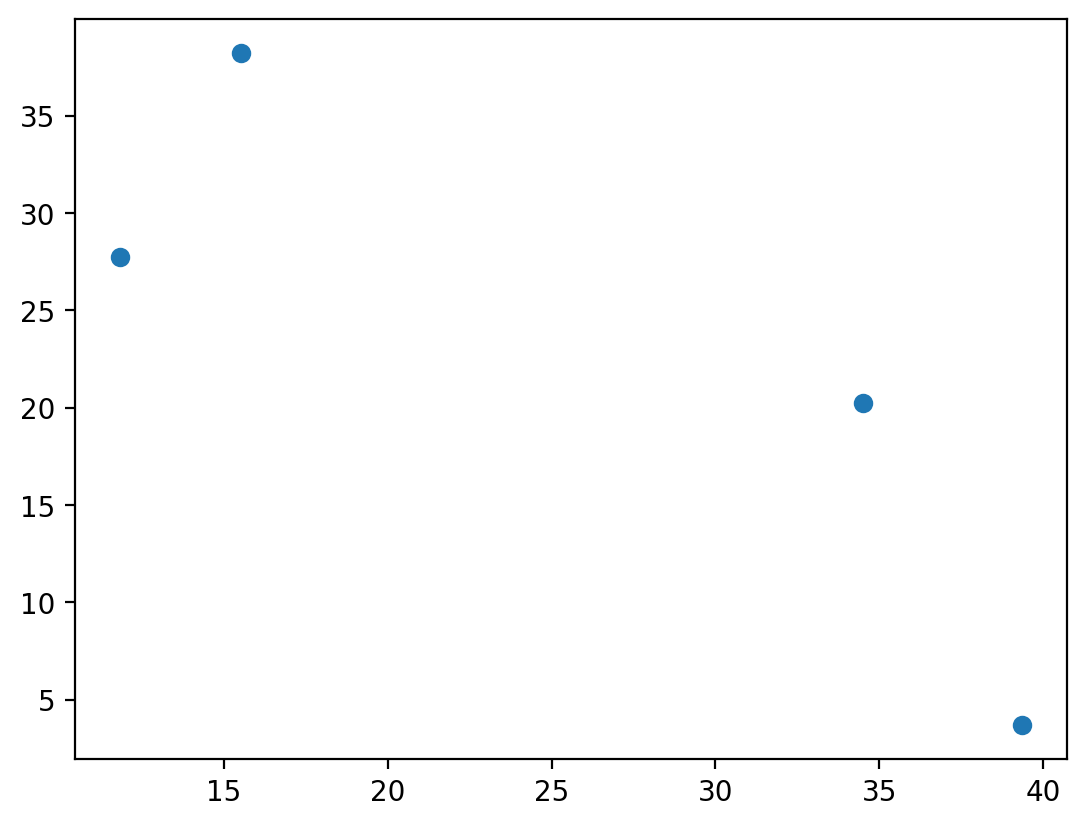

In [15]:
import matplotlib.pyplot as plt

plt.plot(npz['arr_0'][0, :, 1], npz['arr_0'][0, :, 2], 'o')

In [24]:
np.min(npz['arr_0'][:, :, 1])

0.0

In [23]:
np.min(npz['arr_0'][:, :, 2])

0.0

In [21]:
np.min(npz['arr_0'][-1000:, :, 1])

0.8823529411764639

In [22]:
np.min(npz['arr_0'][-1000:, :, 2])

0.08607594936708551

In [146]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0002, momentum=0.9, epochs=20, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=1, eval_epoch=5, s_min=1e-4, s_max=1e-2, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='tanh', sample=True, decoder_n_layer=3)

In [147]:
from models.spatiotemporal.deepstpp import DeepSTPP, train

device = torch.device("cuda:0")

model = DeepSTPP(config, device)
# torch.save(model.state_dict(), 'models/deepstpp-barca.pkl')
best_model = train(model, train_loader, val_loader, config, device)
torch.save(best_model.state_dict(), 'models/deepstpp-barca.pkl')

2023-03-06 11:12:28.987 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 0 | total loss: 1.748257 | Space: 0.700937 | Time: -3.421474
2023-03-06 11:12:34.804 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 1 | total loss: 0.873028 | Space: 1.006054 | Time: -0.999908
2023-03-06 11:12:42.109 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 2 | total loss: 0.581127 | Space: 1.143385 | Time: -0.129397
2023-03-06 11:12:49.714 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 3 | total loss: 0.435146 | Space: 1.219913 | Time: 0.313568
2023-03-06 11:12:56.778 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 4 | total loss: 0.347553 | Space: 1.268512 | Time: 0.582084


Evaluate


2023-03-06 11:12:56.992 | INFO     | models.spatiotemporal.deepstpp:train:443 - Val Loss -0.002729 | Space: 1.504431 | Time: 1.667639
2023-03-06 11:13:03.843 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 5 | total loss: 0.289145 | Space: 1.301626 | Time: 0.762257
2023-03-06 11:13:11.385 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 6 | total loss: 0.247426 | Space: 1.325789 | Time: 0.891615
2023-03-06 11:13:18.948 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 7 | total loss: 0.216136 | Space: 1.344225 | Time: 0.989026
2023-03-06 11:13:24.859 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 8 | total loss: 0.191793 | Space: 1.358422 | Time: 1.065020
2023-03-06 11:13:31.626 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 9 | total loss: 0.172318 | Space: 1.369869 | Time: 1.125959


Evaluate


2023-03-06 11:13:31.829 | INFO     | models.spatiotemporal.deepstpp:train:443 - Val Loss -0.001830 | Space: 1.511303 | Time: 1.678635
2023-03-06 11:13:39.076 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 10 | total loss: 0.156384 | Space: 1.379427 | Time: 1.175861
2023-03-06 11:13:44.345 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 11 | total loss: 0.143106 | Space: 1.387339 | Time: 1.217504
2023-03-06 11:13:49.568 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 12 | total loss: 0.131869 | Space: 1.393991 | Time: 1.252832
2023-03-06 11:13:55.167 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 13 | total loss: 0.122239 | Space: 1.399843 | Time: 1.283095
2023-03-06 11:14:01.765 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 14 | total loss: 0.113893 | Space: 1.404914 | Time: 1.309372


Evaluate


2023-03-06 11:14:02.011 | INFO     | models.spatiotemporal.deepstpp:train:443 - Val Loss -0.002330 | Space: 1.516247 | Time: 1.679000
2023-03-06 11:14:09.702 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 15 | total loss: 0.106589 | Space: 1.409322 | Time: 1.332353
2023-03-06 11:14:17.239 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 16 | total loss: 0.100142 | Space: 1.413279 | Time: 1.352662
2023-03-06 11:14:24.879 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 17 | total loss: 0.094414 | Space: 1.416794 | Time: 1.370727
2023-03-06 11:14:32.417 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 18 | total loss: 0.089289 | Space: 1.419882 | Time: 1.386895
2023-03-06 11:14:39.859 | INFO     | models.spatiotemporal.deepstpp:train:436 - In epochs 19 | total loss: 0.084674 | Space: 1.422749 | Time: 1.401427


Evaluate


2023-03-06 11:14:40.086 | INFO     | models.spatiotemporal.deepstpp:train:443 - Val Loss -0.003167 | Space: 1.511700 | Time: 1.685606


training done!


In [148]:
from models.spatiotemporal.deepstpp import DeepSTPP, train

device = torch.device("cuda:0")
dstpp_model = DeepSTPP(config, device)
dstpp_model.load_state_dict(torch.load('models/deepstpp-barca.pkl'))

<All keys matched successfully>

In [149]:
from models.spatiotemporal.deepstpp import calc_lamb

rtn = calc_lamb(dstpp_model, test_loader, config, device, scales, biases, start_idx=1,
                xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max, round_time=False, x_nstep=31, y_nstep=31, t_nstep=101)
lambs_dstpp, x_range, y_range, t_range_, his_s, his_t = rtn

Intensity time range : 1.0 ~ 3.0


100%|████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 612.27it/s]


In [150]:
fig = plot_lambst_interactive(lambs_dstpp, x_range, y_range, t_range, show=False,
                              master_title='DeepSTPP',
                              subplot_titles=['Ground Truth', 'DeepSTPP'])
fig.write_html(f"temp.html")

### COVID 19 Dataset

In [11]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=True, decoder_n_layer=3)

In [13]:
npz = np.load(f'data/spatiotemporal/covid_nj_cases.npz', allow_pickle=True)
batch_size = 128

train_set = SlidingWindowWrapper(npz['train'], normalized=True)
val_set = SlidingWindowWrapper(npz['val'], normalized=True, min=train_set.min, max=train_set.max)
test_set = SlidingWindowWrapper(npz['test'], normalized=True, min=train_set.min, max=train_set.max)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

scales = (train_set.max - train_set.min).cpu().numpy()
biases = train_set.min.cpu().numpy()

In [5]:
from models.spatiotemporal.deepstpp import DeepSTPP, train

device = torch.device("cuda:0")

model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, device)
torch.save(best_model.state_dict(), 'models/deepstpp-covid.pkl')

2022-12-15 10:24:58.354 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 0 | total loss: 0.246350 | Space: 0.922860 | Time: 3.623649
2022-12-15 10:25:18.726 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 1 | total loss: 0.120899 | Space: 1.079453 | Time: 3.653386
2022-12-15 10:25:40.014 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 2 | total loss: 0.079057 | Space: 1.138364 | Time: 3.662791
2022-12-15 10:26:01.042 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 3 | total loss: 0.058126 | Space: 1.171203 | Time: 3.667077
2022-12-15 10:26:22.496 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 4 | total loss: 0.045563 | Space: 1.191059 | Time: 3.669981
2022-12-15 10:26:22.696 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003823 | Space: 1.192813 | Time: 2.674269


Evaluate


2022-12-15 10:26:43.880 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 5 | total loss: 0.037184 | Space: 1.204658 | Time: 3.671903
2022-12-15 10:27:04.984 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 6 | total loss: 0.031196 | Space: 1.214572 | Time: 3.673342
2022-12-15 10:27:26.422 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 7 | total loss: 0.026704 | Space: 1.222144 | Time: 3.674462
2022-12-15 10:27:46.380 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 8 | total loss: 0.023208 | Space: 1.228123 | Time: 3.675321
2022-12-15 10:28:07.629 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 9 | total loss: 0.020410 | Space: 1.233016 | Time: 3.676005
2022-12-15 10:28:07.823 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003810 | Space: 1.177594 | Time: 2.697553


Evaluate


2022-12-15 10:28:29.811 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 10 | total loss: 0.018120 | Space: 1.237035 | Time: 3.676538
2022-12-15 10:28:51.519 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 11 | total loss: 0.016212 | Space: 1.240326 | Time: 3.677071
2022-12-15 10:29:12.900 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 12 | total loss: 0.014596 | Space: 1.243186 | Time: 3.677482
2022-12-15 10:29:35.263 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 13 | total loss: 0.013210 | Space: 1.245655 | Time: 3.677834
2022-12-15 10:29:57.676 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 14 | total loss: 0.012009 | Space: 1.247801 | Time: 3.678160


Evaluate


2022-12-15 10:29:57.888 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003541 | Space: 1.168100 | Time: 2.699150
2022-12-15 10:30:19.603 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 15 | total loss: 0.010958 | Space: 1.249683 | Time: 3.678446
2022-12-15 10:30:40.076 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 16 | total loss: 0.010030 | Space: 1.251358 | Time: 3.678711
2022-12-15 10:31:01.359 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 17 | total loss: 0.009205 | Space: 1.252848 | Time: 3.678936
2022-12-15 10:31:23.439 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 18 | total loss: 0.008467 | Space: 1.254197 | Time: 3.679134
2022-12-15 10:31:45.629 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 19 | total loss: 0.007802 | Space: 1.255392 | Time: 3.679330
2022-12-15 10:31:45.814 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003665 | Space: 1.1

Evaluate


2022-12-15 10:32:07.648 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 20 | total loss: 0.007200 | Space: 1.256466 | Time: 3.679507
2022-12-15 10:32:30.080 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 21 | total loss: 0.006653 | Space: 1.257483 | Time: 3.679634
2022-12-15 10:32:51.366 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 22 | total loss: 0.006153 | Space: 1.258378 | Time: 3.679779
2022-12-15 10:33:11.708 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 23 | total loss: 0.005695 | Space: 1.259220 | Time: 3.679910
2022-12-15 10:33:33.734 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 24 | total loss: 0.005273 | Space: 1.259980 | Time: 3.680043
2022-12-15 10:33:33.916 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003401 | Space: 1.171525 | Time: 2.696728


Evaluate


2022-12-15 10:33:55.372 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 25 | total loss: 0.004884 | Space: 1.260696 | Time: 3.680145
2022-12-15 10:34:18.765 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 26 | total loss: 0.004523 | Space: 1.261358 | Time: 3.680248
2022-12-15 10:34:40.114 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 27 | total loss: 0.004188 | Space: 1.261975 | Time: 3.680338
2022-12-15 10:35:01.383 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 28 | total loss: 0.003876 | Space: 1.262547 | Time: 3.680422
2022-12-15 10:35:24.038 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 29 | total loss: 0.003585 | Space: 1.263086 | Time: 3.680502
2022-12-15 10:35:24.238 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003737 | Space: 1.170021 | Time: 2.692533


Evaluate


2022-12-15 10:35:47.322 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 30 | total loss: 0.003312 | Space: 1.263603 | Time: 3.680571
2022-12-15 10:36:08.780 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 31 | total loss: 0.003057 | Space: 1.264070 | Time: 3.680649
2022-12-15 10:36:29.354 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 32 | total loss: 0.002816 | Space: 1.264517 | Time: 3.680710
2022-12-15 10:36:50.118 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 33 | total loss: 0.002590 | Space: 1.264942 | Time: 3.680765
2022-12-15 10:37:10.792 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 34 | total loss: 0.002377 | Space: 1.265326 | Time: 3.680839


Evaluate


2022-12-15 10:37:11.026 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003738 | Space: 1.175741 | Time: 2.705305
2022-12-15 10:37:31.479 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 35 | total loss: 0.002176 | Space: 1.265701 | Time: 3.680894
2022-12-15 10:37:51.577 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 36 | total loss: 0.001985 | Space: 1.266050 | Time: 3.680957
2022-12-15 10:38:12.465 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 37 | total loss: 0.001805 | Space: 1.266385 | Time: 3.681016
2022-12-15 10:38:32.328 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 38 | total loss: 0.001633 | Space: 1.266709 | Time: 3.681061
2022-12-15 10:38:52.234 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 39 | total loss: 0.001470 | Space: 1.267010 | Time: 3.681107
2022-12-15 10:38:52.413 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003830 | Space: 1.1

Evaluate


2022-12-15 10:39:13.391 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 40 | total loss: 0.001315 | Space: 1.267305 | Time: 3.681152
2022-12-15 10:39:33.991 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 41 | total loss: 0.001168 | Space: 1.267575 | Time: 3.681201
2022-12-15 10:39:54.178 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 42 | total loss: 0.001027 | Space: 1.267834 | Time: 3.681241
2022-12-15 10:40:13.961 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 43 | total loss: 0.000892 | Space: 1.268086 | Time: 3.681281
2022-12-15 10:40:34.683 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 44 | total loss: 0.000765 | Space: 1.268335 | Time: 3.681314


Evaluate


2022-12-15 10:40:34.912 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003833 | Space: 1.185843 | Time: 2.685667
2022-12-15 10:40:55.905 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 45 | total loss: 0.000641 | Space: 1.268573 | Time: 3.681351
2022-12-15 10:41:15.776 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 46 | total loss: 0.000523 | Space: 1.268790 | Time: 3.681391
2022-12-15 10:41:36.077 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 47 | total loss: 0.000411 | Space: 1.268994 | Time: 3.681432
2022-12-15 10:41:56.619 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 48 | total loss: 0.000302 | Space: 1.269200 | Time: 3.681459
2022-12-15 10:42:17.522 | INFO     | models.spatiotemporal.deepstpp:train:434 - In epochs 49 | total loss: 0.000198 | Space: 1.269391 | Time: 3.681495
2022-12-15 10:42:17.708 | INFO     | models.spatiotemporal.deepstpp:train:441 - Val Loss -0.003840 | Space: 1.1

Evaluate
training done!


In [14]:
START_IDX = 2

his_st = []
for _, _, st_x, st_y, loc in test_loader:
    if START_IDX not in loc[0]:
        continue
    his_st.append(st_y[np.where(loc[0] == START_IDX)])
    
his_st = torch.cat(his_st, 0).squeeze(1).detach().cpu().numpy()

T_START = his_st[:, -1][0]
T_END   = his_st[:, -1][-1]

In [3]:
from models.spatiotemporal.deepstpp import calc_lamb

model = torch.load('models/deepstpp.pkl')
rtn = calc_lamb(model, test_loader, config, device, scales, biases, 
                round_time=False, x_nstep=31, y_nstep=31, t_nstep=101)
lambs_dstpp, x_range, y_range, t_range, his_s, his_t = rtn
x_min, x_max = x_range[0], x_range[-1]
y_min, y_max = y_range[0], y_range[-1]

KeyboardInterrupt: 

In [7]:
from models.spatiotemporal.model import AutoIntSTPPSameInfluence, calc_lamb
from integration.autoint import Cuboid
import torch

cuboid = Cuboid()
device = torch.device('cuda:0')
model = AutoIntSTPPSameInfluence(cuboid, device=device).to(device)
model_fn = 'models/test/test_autoint_3d_dataset/dataloader={name=covid_nj_cases},model={act=requ,n_layers=3,hid_dim=128},trained_model={name=auto-stpp}.pkl'
model.load_state_dict(torch.load(model_fn)['model_state_dict'])

<All keys matched successfully>

In [8]:
rtn = calc_lamb(model, test_loader, device, scales, biases, 
                xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max, 
                round_time=False, x_nstep=31, y_nstep=31, t_nstep=101)
lambs_autoint, x_range, y_range, t_range_, his_s, his_t = rtn

NameError: name 'x_min' is not defined

In [13]:
np.max(lambs_dstpp)

146.1195

In [14]:
fig = plot_lambst_interactive([lambs_autoint, lambs_dstpp], x_range, y_range, t_range, show=False, cmax=147,
                              master_title='COVID-19 Comparison',
                              subplot_titles=['Auto-STPP', 'Deep-STPP'])
fig.write_html(f"temp1.html")